# <center>Big Data &ndash; Exercises</center>
## <center>Fall 2024 &ndash; Week 12 &ndash; ETH Zurich</center>
## <center>Graph Databases</center>

---
### Introduction
Data relationships are extremely important in today’s world; Data alone is not enough, as enterprise leaders and intelligent applications need real-time insights into data relationships. 

Labeled property graph databases use nodes, edges, properties, and labels to store and retrieve data. The graph structures directly **relate** data items in the store. As a representative of (labeled property) graph databases, **Neo4j** was chosen for the practical exercises. We will see how using **Cypher**, a graph query language for Neo4j, makes querying relationships easier than using SQL with traditional RDBMSs.

### Database Set Up
Like always, you can start the docker container with `docker-compose up -d`. The Neo4j image should work on all systems, but in the case that it fails you can either try starting the docker on an Azure VM, or installing the server locally:
- Click on [this link](https://neo4j.com/download-center/#releases) to download the Community Server Edition for individuals. 
- Follow the installation steps provided in the Neo4j website to install it on your computer.

Once the container has fully started you can access the Neo4j browser interface at http://localhost:7474/browser/, after which you will see an authentication box like so:

<img src="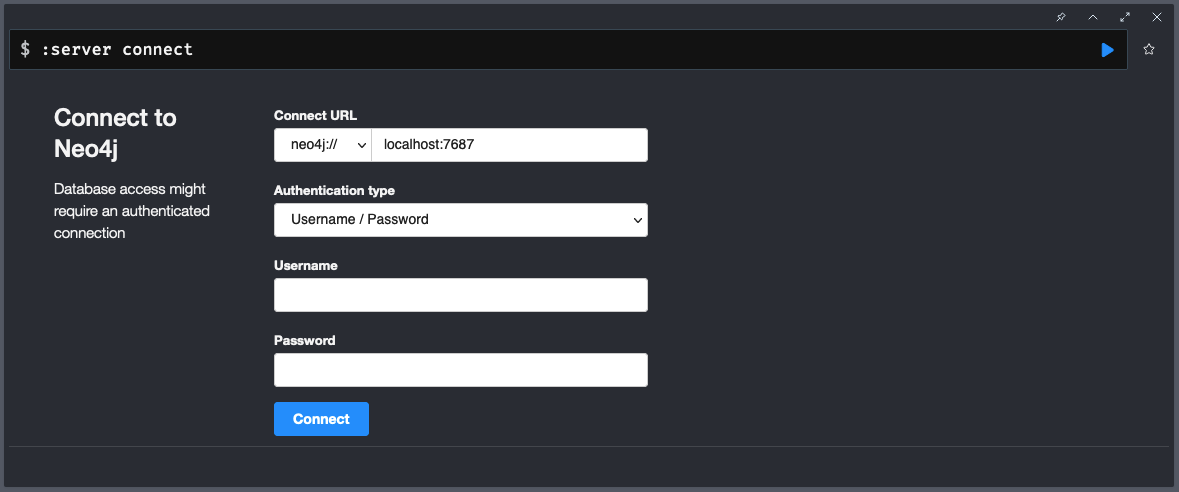
"/>

The default username and password are both `neo4j`, after which you will have access to the `neo4j` database! If you are using the local installation, you will have to change to password to whatever you wish.

---
## Exercise 1: Movie graph
Let's query a default movie graph using Cypher, one of the provided graph query languages for Neo4j. For any doubt about the queries or to explore more in-depth you can refer to [Cypher documentation](https://neo4j.com/docs/cypher-manual/current/).



<img src="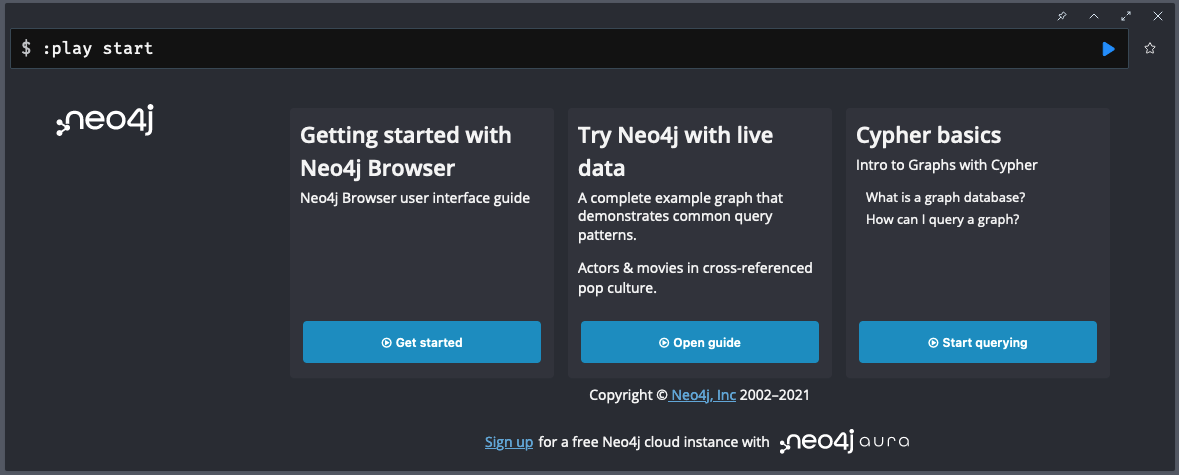
"/>


### Setting up the movie graph

To begin, let's open the `movie-graph` guide by either clicking 'Open Guide' or running `:guide movie-graph` in the web interface, after which a guide panel will appear on the left.

Follow steps 2, 3, and 4 to create the movie graph!

<img src="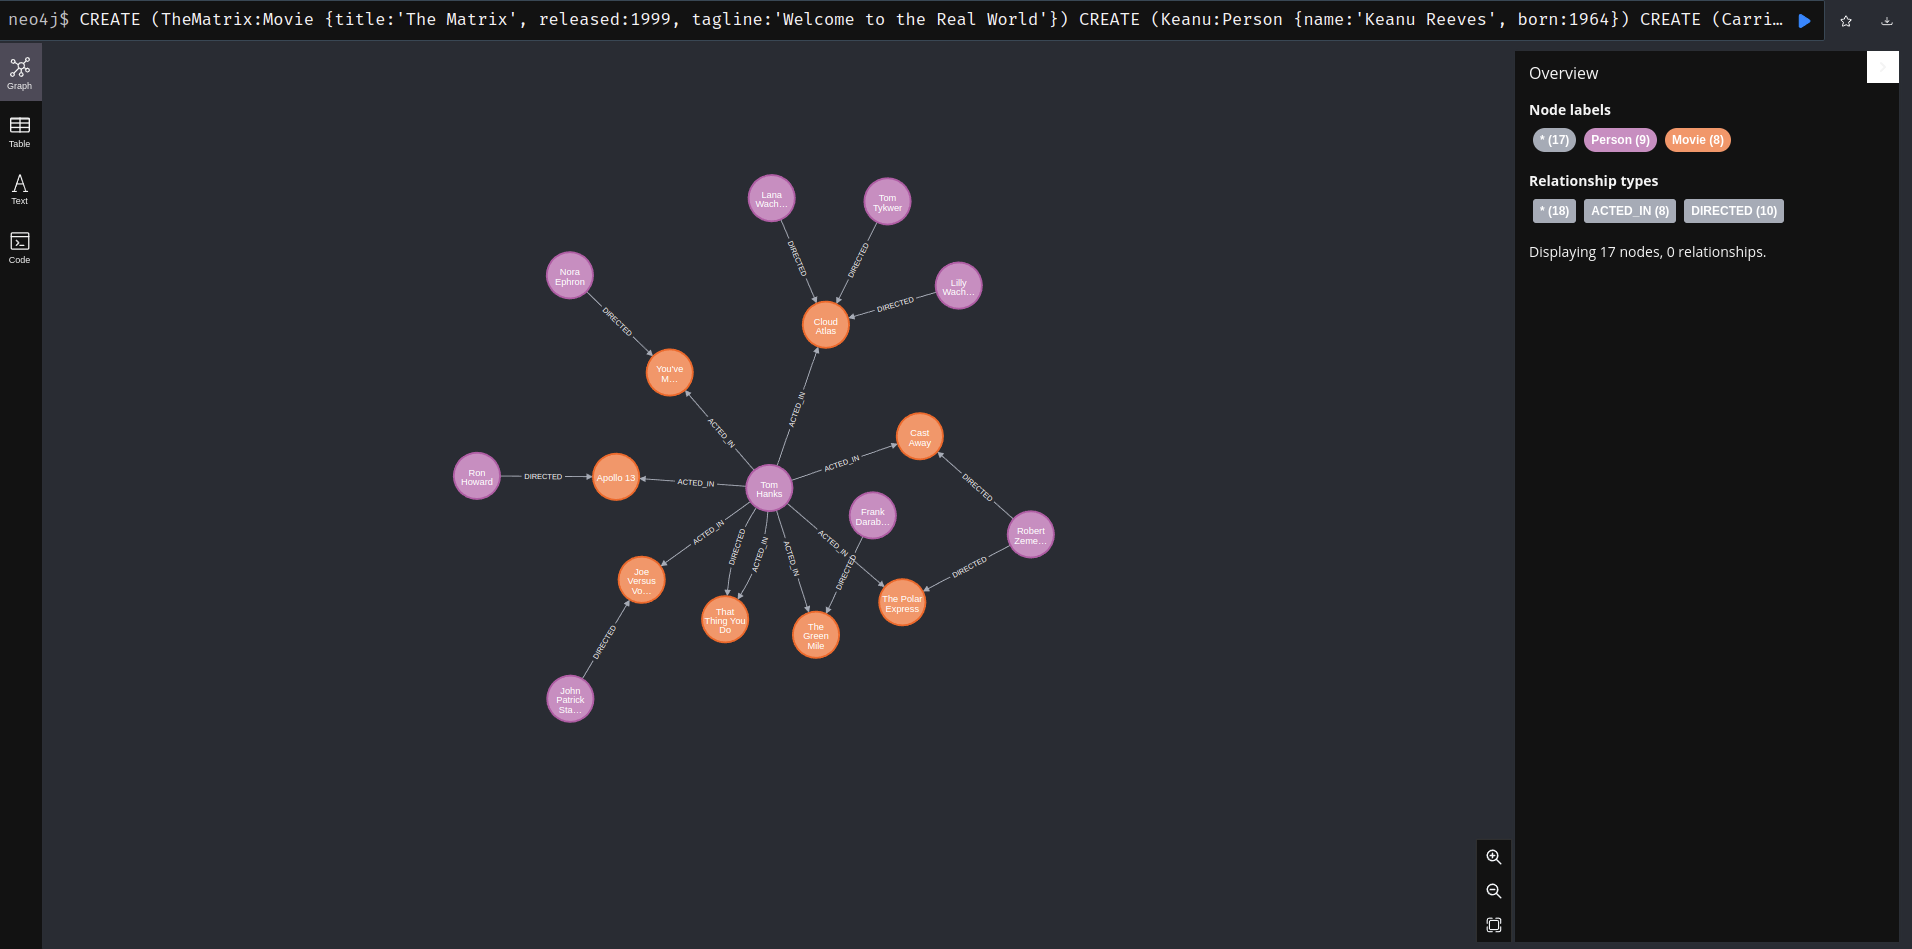
"/>

### Querying the movie graph
Now, let's write some Cypher queries to answer the following questions! Many of these queries will be similar to queries shown in the guide, and just need a little bit of our own work.

##### 1. Write a query that returns the title of all movies a "Tom" has acted in (the actor's name starts with "Tom").

In [ ]:

MATCH (p:Person)-[:ACTED_IN]->(m)
WHERE p.name STARTS WITH "Tom"
RETURN m.title


An alternative using regular expressions:

In [ ]:

MATCH (p:Person)-[:ACTED_IN]->(m)
WHERE p.name =~ "Tom.*"
RETURN m.title as mtitle ORDER BY mtitle DESC


As you can see in the results of the above queries (easier in the ordered one), Neo4j does not eliminate duplicates by default. This can be done by using the `RETURN DISTINCT` keyword, which is equivalent to the `SELECT DISTINCT` in SQL. Therefore the above query could be rewritten as follows:

In [ ]:

MATCH (p:Person)-[:ACTED_IN]->(m)
WHERE p.name STARTS WITH "Tom"
RETURN DISTINCT m.title

##### 2. What is the shortest path (using any kind of relation) between Keanu Reeves and Tom Cruise? How long is it?

In [ ]:

MATCH (p1:Person { name: "Keanu Reeves" }),
      (p2:Person { name:"Tom Cruise" }),
      p = shortestPath((p1)-[*..15]-(p2))
RETURN p, length(p)


Note that it is considered good practice to always put an upper bound when considering multi-hop relations (in the query `[*..15]`) to avoid the risk of infinite looping for cyclic graphs.

##### 3. How long are the shortest paths between anyone with first name "Keanu" and anyone with first name "Tom"?

In [ ]:

MATCH (p1:Person),(p2:Person), 
      p = shortestPath((p1)-[*..15]-(p2))
WHERE p1.name STARTS WITH "Keanu"
AND p2.name STARTS WITH "Tom"
RETURN p1.name,p2.name,length(p)

##### 4. What is the maximal distance of any person to Kevin Bacon in the graph?

In [ ]:

MATCH (p1:Person),(p2:Person), p = shortestPath((p1)-[*]-(p2))
WHERE p1.name = "Kevin Bacon" AND p1 <> p2
WITH length(p) AS length
RETURN max(length) AS maxLength

---
## Exercise 2: Choosing the right technology

In the following cases choose which technology you would prefer between a *Document Store*, a *Graph Database* and a *Relational Database*.

1. You want to run large-volume analytics queries that have a clear structure.
2. You often query for aggregated information (e.g. average).
3. You often query for relationships of more than one hops (e.g. who is the friend of friend of somebody).
4. Your data have an arborescent structure and cannot fit on a single machine. 
5. You are building an application that stores semistructured product information.

In [ ]:

1. Relational Database
2. Relational Database
3. Graph Database
4. Document Store
5. Document Store

---
## Exercise 3: Graphs to tables

1. Given the movie graph that we explored, try to come up with an equivalent tabular representation in 3rd normal form.
2. Do you think that for this specific dataset can be captured well in tabular form?
3. Which might be a general strategy to turn any labelled graph to a table form?
4. Which queries do you expect easier to write in CYPHER compared to SQL?

In [ ]:


1. One possible solution might look like the following:

> movies: (**title**, released, tagline)
>
> people: (**name**, born)
>
> directed: (**director_name, movie_title**)
>
> produced: (**producer_name, movie_title**)
>
> acted_in: (**actor_name, movie_title, role**)

2. Since this specific graph is quite simple and consistent, it captured well and quite easily by a tabular form.
3. It depends on the specific graph, but a general strategy could be to create tables for each node type and each relation type, you might need to create additional tables to store non-flat properties of nodes or relations.
4. Queries involving multiple hops detection or information about shortest paths.

---
## Exercise 4: Discogs graph
For this exercise, we will work with a subset of the Discogs dataset from the SQL brush-up exercise. The dataset only contains artists who have released at least one album in the genre 'Rock', 'Pop', or 'Hip Hop'. The dataset also drops the `tracks` table, and projects a subset of columns. 

### Setting up the Discogs graph
First, run the following commands to add nodes to our graph:

In [ ]:
LOAD CSV WITH HEADERS FROM "https://cloud.inf.ethz.ch/s/KxbAmipoHyDS4Qd/download" AS row
WITH row LIMIT 1000000
CREATE (n:Artist)
SET n += row

In [ ]:
LOAD CSV WITH HEADERS FROM "https://cloud.inf.ethz.ch/s/YerWSEP3pD9W9q6/download" AS row
CREATE (n:Release)
SET n += row

In [ ]:
LOAD CSV WITH HEADERS FROM "https://cloud.inf.ethz.ch/s/K757RBQ8Dsm3m9H/download" AS row
CREATE (n:ReleasedBy)
SET n += row

Then, let's add some uniqueness constraints (which create implicit indexes) and an index on the artist `name`:

In [ ]:
CREATE CONSTRAINT FOR (a:Artist) REQUIRE (a.artist_id) IS UNIQUE

In [ ]:
CREATE CONSTRAINT FOR (r:Release) REQUIRE (r.release_id) IS UNIQUE

In [ ]:
CREATE INDEX FOR (a:Artist) ON (a.name)

Finally, let's create a `RELEASED_BY` relationship between artists and releases based on the `released_by` table:

In [ ]:
MATCH (a:Artist), (r:Release), (rb:ReleasedBy)
WHERE a.artist_id = rb.artist_id
AND rb.release_id = r.release_id
CREATE (r)-[:RELEASED_BY]->(a)

### Querying the Discogs graph

Remember some of the queries we did on the original database in SQL? Try writing them in Cypher instead:

##### 1. Retrieve all artists with the name of 'Radiohead'.

In [ ]:
SELECT * FROM artists WHERE name = 'Radiohead';

In [ ]:

MATCH (a:Artist {name: "Radiohead"}) RETURN a

##### 2. How many artists have both a release with the genre 'Pop' and a release with the genre 'Rock'?

In [ ]:
SELECT COUNT(*)
FROM artists a1
WHERE EXISTS (
    SELECT *
    FROM artists a2
    JOIN released_by USING(artist_id)
    JOIN releases USING(release_id)
    WHERE releases.genre = 'Pop'
    AND a1.artist_id = a2.artist_id
) AND EXISTS (
    SELECT *
    FROM artists a2
    JOIN released_by USING(artist_id)
    JOIN releases USING(release_id)
    WHERE releases.genre = 'Rock'
    AND a1.artist_id = a2.artist_id
)

In [ ]:

MATCH (r1:Release {genre: "Pop"})-[:RELEASED_BY]->(a:Artist)<-[:RELEASED_BY]-(r2:Release {genre: "Rock"}) RETURN count(DISTINCT a)

### Artist collaborations
Do you remember this query from the optional exercise?

In [ ]:
WITH RECURSIVE
    X AS (SELECT 3 AS Value),
    artist_releases AS (
        SELECT artists.artist_id, artists.name, releases.release_id, releases.title
        FROM artists, released_by, releases
        WHERE artists.artist_id = released_by.artist_id
        AND released_by.release_id = releases.release_id
    ),
    collaborations AS (
        SELECT DISTINCT ar1.artist_id AS left_id, ar1.name AS left_name, 
                ar2.artist_id AS right_id, ar2.name AS right_name, 1 AS distance
        FROM artist_releases AS ar1, artist_releases AS ar2
        WHERE ar1.release_id = ar2.release_id
        AND ar1.artist_id != ar2.artist_id
    ),
    X_hop_collaborations AS (
        SELECT * FROM collaborations  -- base case
        UNION
        SELECT c1.left_id, c1.left_name, c2.right_id, c2.right_name, c1.distance + 1 AS distance
        FROM X_hop_collaborations AS c1
        JOIN collaborations c2 ON c1.right_id = c2.left_id
        WHERE c1.distance < (SELECT * FROM X)
    )
SELECT * 
FROM X_hop_collaborations
WHERE left_name = 'Radiohead'
ORDER BY distance, right_name;

The query returns all of the artists which are at most `X` hops from a given artist in the graph. It does this by iteratively taking the union of a base 'collaborations' table with itself. With our discogs graph, we can do this very concisely:

In [ ]:
MATCH (a:Artist)<-[:RELEASED_BY]-(:Release)-[:RELEASED_BY]->(collab:Artist),
(collab)<-[:RELEASED_BY]-(:Release)-[:RELEASED_BY]->(collab2:Artist),
(collab2)<-[:RELEASED_BY]-(:Release)-[:RELEASED_BY]->(collab3:Artist)
WHERE a.name = "The Beatles"
RETURN a, collab, collab2, collab3

However, we would ideally like to be able to use the `shortestPath` function and `[*1..15]` 'hops' features of Cypher as well. For that, we need to modify the graph to put a direct relationship between artists that have collaborated together:

In [ ]:
MATCH (a:Artist)<-[:RELEASED_BY]-(release)-[:RELEASED_BY]->(a2:Artist)
MERGE (a)-[:COLLABORATED_WITH]->(a2)
RETURN a, a2

Now, let's try use this new `COLLABORATED_WITH` relationship instead!

##### 3. Find all of the artists which are up to three hops away from "The Beatles".

In [ ]:

MATCH (a:Artist {name: "The Beatles"})-[:COLLABORATED_WITH*1..3]-(collab:Artist) 
RETURN collab

##### 4. What is the shortest path between the artists "Black Tiger" and "Kanye West"?

In [ ]:

MATCH (a:Artist {name: "Black Tiger"}), (b:Artist {name: "Kanye West"}), p = shortestPath((a)-[:COLLABORATED_WITH*]-(b))
RETURN p

---
## Exercise 5: RDF Triples
We know that triple graphs can be modeled by RDF triples in the form of `subject property object`.

<img src="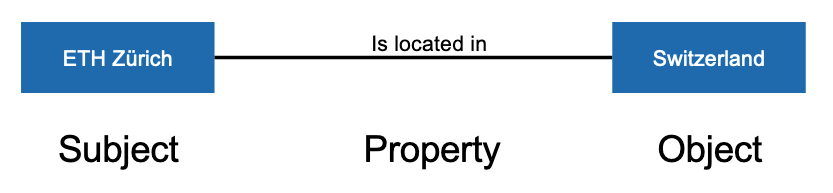
">

In this exercise, we'll spend a little bit of time understanding how RDF triple syntaxes can model semantic relationships. More specifically, given the following **Turtle** document, draw the triple graph that it models. 

```
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix geo:     <http://www.example.com/geography#> .
@prefix ch:      <https://www.example.com/Switzerland#> .
@prefix uni:     <http://www.example.com/university#> .

@prefix eth:     <http://www.ethz.ch/#> .
@prefix course:  <http://www.ethz.ch/Course/> .
@prefix faculty: <http://www.ethz.ch/Faculty/> .

eth:self rdfs:label "ETH Zürich" ;
         geo:isLocated ch:self ;
         uni:numStudents 25000 .
         
eth:Zentrum rdfs:label "ETHZ Zentrum Campus" ;
            uni:campusOf eth:self ;
            geo:isLocated ch:Zürich ;
            geo:hasPostcode 8092 .
               
eth:Hönggerberg rdfs:label "ETHZ Hönggerberg Campus" ;
                uni:campusOf eth:self ;
                geo:isLocated ch:Zürich ;
                geo:hasPostcode 8093 .

faculty:gfourny rdfs:label "Ghislain Fourny" ;
                uni:facultyAt eth:self ;
                uni:teaches course:263-3010-00L .
                
course:263-3010-00L rdfs:label "Big Data" ;
                    rdfs:comment "Decent course" ;
                    uni:numStudents 242 ;
                    uni:offeredAt eth:self ;
                    uni:offeredIn "HS2023" ,
                                  "HS2022" ;
                    # and more, but let's ignore those in this example
                    uni:numCredits 10 .            
```

Note that this example is just to give you a basic understanding of how RDF triples _might_ be modeled: IRIs will not point to anything meaningful, and many objects that would be IRIs have been simplified to literals.

### Exercise 5: Solution
The resulting triple graph might look like this:

<img src="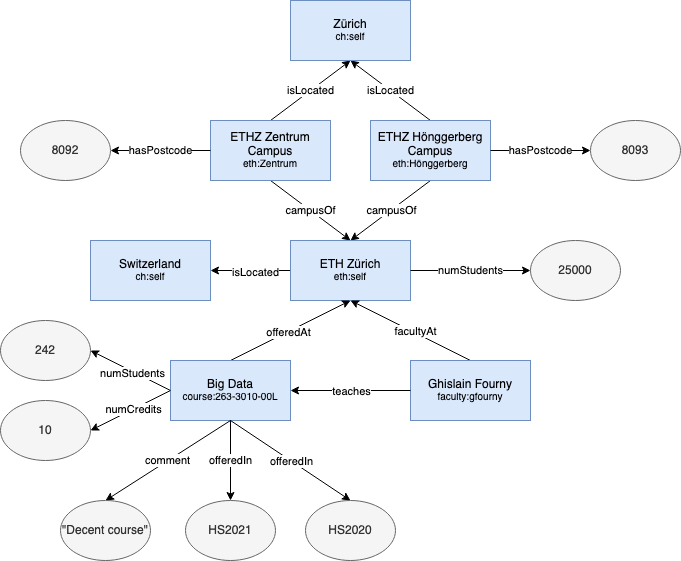
"/>

Of course, there is no set way to represent this and your solution may be different! We may also think about some triples that may be defined in the individual prefix domains:

```
ch:Zürich rdfs:label "Zürich" ;
          geo:isLocated ch:self .
          
ch:self rdfs:Label "Switzerland" ;
        geo:isLocated geo:Europe .
        
# ...etc

uni:facultyAt rdfs:subPropertyOf rdfs:member .
uni:campusOf rdfs:subPropertyOf geo:isLocated .
uni:numStudents rdfs:subPropertyOf geo:population .        
```

---
## Exercise 6: Knowledge Graphs (Optional)

Knowledge graphs are often chosen to represent large inter-connected entities, and are used by many well-known knowledge bases. Examples include the [Google Knowledge Graph](https://blog.google/products/search/introducing-knowledge-graph-things-not/) and [Wikidata](https://en.wikipedia.org/wiki/Wikidata), a knowledge graph used by many Wikimedia projects: notably Wikipedia.

We will be using the [Wikidata Query Service](https://query.wikidata.org), which allows us to query the Wikidata knowledge graph using **SPARQL**, a declarative SQL-like query language for RDF data. Note:
* Although Wikidata can be accessed via SPARQL with an RDF-like data model, their underlying data does not follow RDF exactly.
* Here, we are only querying to knowledge graph to retrieve _explicit knowledge_. We cannot perform logical inference without an ontology (like [OWL](https://www.w3.org/OWL/)) and a reasoner!

### Retrieving some basic facts with SPARQL

You can use the 'Examples' section to see a wide variety of example SPARQL queries. Here are a few select ones to help you get the hang of querying Wikidata:

##### Retrieve all 'house cat' entities

In [ ]:
SELECT ?item ?itemLabel 
WHERE 
{
  ?item wdt:P31 wd:Q146. # Must be of a cat
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}

[Link to this query](https://query.wikidata.org/#%23Cats%0ASELECT%20%3Fitem%20%3FitemLabel%20%0AWHERE%20%0A%7B%0A%20%20%3Fitem%20wdt%3AP31%20wd%3AQ146.%20%23%20Must%20be%20of%20a%20cat%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22%5BAUTO_LANGUAGE%5D%2Cen%22.%20%7D%20%23%20Helps%20get%20the%20label%20in%20your%20language%2C%20if%20not%2C%20then%20en%20language%0A%7D)

Here, we can see how we query for any entities that are an instance of (`wdt:P31`) the entity with the label 'house cat' `wd:Q146`, and store them in a variable `?item`. We choose to return the entity itself and also its label `?itemLabel`. Now, lets get some pictures of those cats!

In [ ]:
#defaultView:ImageGrid
SELECT ?item ?itemLabel ?pic
WHERE
{
    ?item wdt:P31 wd:Q146 .
    ?item wdt:P18 ?pic
    SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en" }
}

[Link to this query](https://query.wikidata.org/#%23Cats%2C%20with%20pictures%0A%23defaultView%3AImageGrid%0ASELECT%20%3Fitem%20%3FitemLabel%20%3Fpic%0AWHERE%0A%7B%0A%3Fitem%20wdt%3AP31%20wd%3AQ146%20.%0A%3Fitem%20wdt%3AP18%20%3Fpic%0ASERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22%5BAUTO_LANGUAGE%5D%2Cen%22%20%7D%0A%7D)

Here, we also retrieve any associated pictures of the cats with the image property `wdt:P18`. However, instances is pretty restricting, and sometimes we want to also retrieve any subclasses as well.

##### Retrieve all watercourses in Antarctica

In [ ]:
SELECT ?river ?riverLabel ?location
WHERE
{
    ?river wdt:P31/wdt:P279* wd:Q355304;
           wdt:P30 wd:Q51.
    OPTIONAL { ?river wdt:P625 ?location. }
    SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}

[Link to this query](https://query.wikidata.org/#%23Rivers%20in%20Antarctica%0ASELECT%20%3Friver%20%3FriverLabel%20%3Flocation%0AWHERE%0A%7B%0A%20%20%3Friver%20wdt%3AP31%2Fwdt%3AP279%2a%20wd%3AQ355304%3B%20%23%20watercourse%3B%20includes%20a%20few%20creeks%20%E2%80%93%20use%20wd%3AQ4022%20for%20rivers%20only%0A%20%20%20%20%20%20%20%20%20wdt%3AP30%20wd%3AQ51.%0A%20%20OPTIONAL%20%7B%20%3Friver%20wdt%3AP625%20%3Flocation.%20%7D%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22en%22.%20%7D%0A%7D)

Here, we specify that our `?river` entity can not only be an instance of a 'watercourse' `wd:Q355304`, but also any arbitrary depth subclass (`wdt:P279*`). We also specify that the continent `wdt:P30` of the entity must be Antarctica `wd:Q51`.

### Planning your winter break in Switzerland

The date is February 11th, 2022: you're done with the Big Data exam and now it's finally time to emerge from your dwelling and go outside, but you have no idea where you can go!
Using this query to retrieve all [Italian mountains higher than 4000 meters](https://query.wikidata.org/#%23Italian%20mountains%20higher%20than%204000%20meters%0A%23defaultView%3AImageGrid%0ASELECT%20%3Fitem%20%3FitemLabel%20%3Fcoord%20%3Felev%20%3Fpicture%0A%7B%0A%20%20%3Fitem%20p%3AP2044%2Fpsn%3AP2044%2Fwikibase%3AquantityAmount%20%3Felev%20%3B%20%20%23%20normalized%20height%0A%20%20%20%20%20%20%20%20wdt%3AP625%20%3Fcoord%20%3B%0A%20%20%20%20%20%20%20%20wdt%3AP17%20wd%3AQ38%20%3B%0A%20%20%20%20%20%20%20%20wdt%3AP18%20%3Fpicture%0A%20%20FILTER%28%3Felev%20%3E%204000%29%0A%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22it%22%20%7D%0A%7D) as a reference, answer for yourself the following questions:

##### 1. List all the lakes in Switzerland above 2000 meters elevation.

You might want to use the lake entity `wd:Q23397` and the Switzerland entity `wd:Q39`.

In [ ]:

#defaultView:ImageGrid
SELECT ?lake ?lakeLabel ?coord ?elev ?picture
{
    ?lake p:P2044/psn:P2044/wikibase:quantityAmount ?elev ;  # normalized height
        wdt:P31 wd:Q23397;
        wdt:P625 ?coord;
        wdt:P17 wd:Q39 ;
        wdt:P18 ?picture
    FILTER(?elev > 2000)

    SERVICE wikibase:label { bd:serviceParam wikibase:language "de" }
}

[Link to this query](https://query.wikidata.org/#%23defaultView%3AImageGrid%0ASELECT%20%3Flake%20%3FlakeLabel%20%3Fcoord%20%3Felev%20%3Fpicture%0A%7B%0A%20%20%20%20%3Flake%20p%3AP2044%2Fpsn%3AP2044%2Fwikibase%3AquantityAmount%20%3Felev%20%3B%20%20%23%20normalized%20height%0A%20%20%20%20%20%20%20%20wdt%3AP31%20wd%3AQ23397%3B%0A%20%20%20%20%20%20%20%20wdt%3AP625%20%3Fcoord%3B%0A%20%20%20%20%20%20%20%20wdt%3AP17%20wd%3AQ39%20%3B%0A%20%20%20%20%20%20%20%20wdt%3AP18%20%3Fpicture%0A%20%20%20%20FILTER%28%3Felev%20%3E%202000%29%0A%0A%20%20%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22de%22%20%7D%0A%7D)

##### 2. List all the mountains in Switzerland. You also want to know the canton each mountain is located in, so you know how to greet the locals.

You might want to use the following entities:
* mountain `wd:Q8502`
* located in the administrative territorial entity `wdt:P131`
* canton of Switzerland `wd:Q23058`

In [ ]:

#defaultView:ImageGrid
SELECT ?mountain ?mountainLabel ?mountainDescription ?coord ?picture ?adminRegionLabel
{
    ?mountain wdt:P31 wd:Q8502;
            wdt:P625 ?coord;
            wdt:P17 wd:Q39;
            wdt:P18 ?picture;
            wdt:P131 ?adminRegion.
    ?adminRegion wdt:P31 wd:Q23058;

    SERVICE wikibase:label { bd:serviceParam wikibase:language "de" }
}

[Link to this query](https://query.wikidata.org/#%23defaultView%3AImageGrid%0ASELECT%20%3Fmountain%20%3FmountainLabel%20%3FmountainDescription%20%3Fcoord%20%3Fpicture%20%3FadminRegionLabel%0A%7B%0A%20%20%3Fmountain%20wdt%3AP31%20wd%3AQ8502%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20wdt%3AP625%20%3Fcoord%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20wdt%3AP17%20wd%3AQ39%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20wdt%3AP18%20%3Fpicture%3B%0A%20%20%20%20%20%20%20%20%20%20%20%20wdt%3AP131%20%3FadminRegion.%0A%20%20%3FadminRegion%20wdt%3AP31%20wd%3AQ23058%3B%0A%20%20%20%20%20%20%20%20%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22de%22%20%7D%0A%7D)